In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
data_path = r"/shared/netscratch/znjs2/atom_data_02_20/processed/all_atom_ch4_data_datetime.csv"

In [37]:
ch4_data = pd.read_csv(data_path, delimiter=',', 
                        na_values = [-99999, -9999, -999, -888], 
                        parse_dates=[0], 
                        index_col=0)

#Get rid of NA vals
ch4_data = ch4_data.dropna(subset=['CH4_PECD'])
print(ch4_data.shape)

#print(ch4_data.iloc[:3])

(7208, 9)


In [38]:
#check which months present
months_present, counts = np.unique(pd.DatetimeIndex(ch4_data.index).month, return_counts=True)

print(months_present)
print(np.asarray((months_present, counts)).T)

[ 1  2  4  5  7  8  9 10]
[[   1  376]
 [   2 1317]
 [   4  487]
 [   5 1608]
 [   7  160]
 [   8 1368]
 [   9  199]
 [  10 1693]]


In [4]:
#add month column
#ch4_data['month'] = pd.DatetimeIndex(ch4_data.index).month

In [40]:
#bin by latitude
ch4_data['lat_bins'] = pd.cut(ch4_data.iloc[:,0],[-90,-60,-30,0,30,60,90], 
                              labels=list(range(6)))

In [41]:
print(ch4_data.iloc[:3])

                        G_LAT     G_LONG   G_ALT  CH4_PECD  CH4e_PECD  \
UTC_Start_dt                                                            
2017-10-27 18:27:07  61.05862 -150.13286  1515.1    1944.9       16.6   
2017-10-27 18:29:27  60.92700 -149.89032  2739.2    1935.1       16.6   
2017-10-27 18:34:07  60.63194 -149.14904  4632.9    1939.7       16.6   

                     CH4_GMI  CH4_NOAA  CH4_UCATS  CH4e_UCATS lat_bins  
UTC_Start_dt                                                            
2017-10-27 18:27:07      NaN   1936.32        NaN         NaN        5  
2017-10-27 18:29:27      NaN   1936.33        NaN         NaN        5  
2017-10-27 18:34:07      NaN   1931.06        NaN         NaN        5  


In [68]:
#make seperate data frame for each month
monthly_ch4 = {}
for x in range(len(months_present)):
        monthly_ch4[f'ch4_{months_present[x]}'] = ch4_data[pd.DatetimeIndex(ch4_data.index).month == months_present[x]]
    
#print(monthly_ch4)

In [81]:
#bin data by season
ch4_jf = pd.concat((monthly_ch4.get('ch4_7'),monthly_ch4.get('ch4_8')))
print(monthly_ch4.get('ch4_1').shape)
print(monthly_ch4.get('ch4_2').shape)
print(ch4_jf.shape)

(376, 10)
(1317, 10)
(1528, 10)


In [70]:
print(ch4_jf)

                        G_LAT     G_LONG    G_ALT  CH4_PECD  CH4e_PECD  \
UTC_Start_dt                                                             
2017-01-26 17:20:09  34.36746 -118.12504   3914.6    1909.7       13.0   
2017-01-26 17:22:29  34.17046 -118.18395   4741.8    1903.3       13.0   
2017-01-26 17:24:49  33.93482 -118.25508   5621.2    1912.3       13.0   
2017-01-26 17:27:09  33.70053 -118.32483   6574.7    1910.9       13.0   
2017-01-26 17:31:49  33.26587 -118.56495   7899.6    1912.4       13.0   
...                       ...        ...      ...       ...        ...   
2017-02-11 04:21:54 -54.56296  -72.27762  11855.8    1777.1       17.7   
2017-02-11 04:24:14 -54.32451  -72.01130   9944.5    1785.7       17.7   
2017-02-11 04:26:34 -54.09477  -71.75596   8085.2    1800.9       17.7   
2017-02-11 04:28:54 -53.87357  -71.51448   6316.3    1808.4       17.7   
2017-02-11 04:33:34 -53.47665  -71.07594   3174.4    1770.2       17.7   

                     CH4_GMI  CH4_NOA

In [82]:
#how many data points in each lat bin?
lat_bins, counts = np.unique(ch4_jf.iloc[:,9], return_counts=True)

print(lat_bins)
print(np.asarray((lat_bins, counts)).T)

[0 1 2 3 4 5]
[[  0 106]
 [  1 285]
 [  2 181]
 [  3 271]
 [  4 377]
 [  5 308]]


In [95]:
#should define a function for this

lat_bands_obs_jf = np.empty((6,50))
base_obs_jf = np.zeros(6)

yvals = np.linspace(0,12000)

for i in range(6):
    #select data by latitude band
    lat_band = ch4_jf.loc[ch4_jf['lat_bins'] == i].iloc[:,[0,2,3]].dropna()
    #generate coefficients and make function
    coefs = np.polyfit(lat_band.iloc[:,1],lat_band.iloc[:,2],2)
    fit = np.poly1d(coefs)
    base_obs_jf[i] = fit(0) #set zero value
    lat_bands_obs_jf[i] = fit(yvals)
    
print(lat_bands_obs_jf.shape)
#np.save('/shared/netscratch/znjs2/atom_data_02_20/ch4_lat_binned_jf.npy', lat_bands_obs_jf)

(6, 50)


Text(0.5, 1.0, 'CH4 Profile')

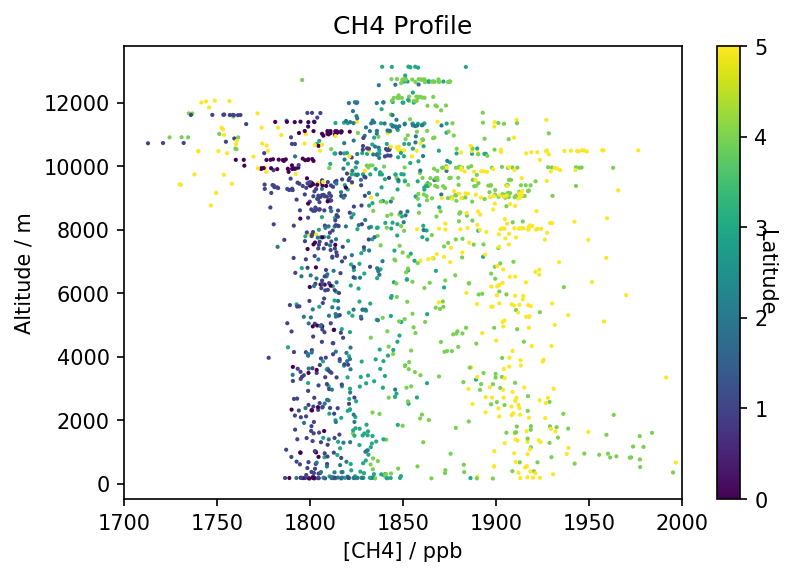

In [94]:
fig = plt.figure(dpi=150)
ax = plt.axes()
plot = ax.scatter(ch4_jf.iloc[:,3],ch4_jf.iloc[:,2],s=1, c=ch4_jf.iloc[:,9])

cbar = plt.colorbar(plot)
cbar.set_label('Latitude', rotation=270)
ax.set_xlim(1700,2000)
plt.xlabel('[CH4] / ppb')
plt.ylabel('Altitude / m')
plt.title(f'CH4 Profile')

Text(0.5, 1.0, 'CH4 Profile: model with emissions (xltln) JA')

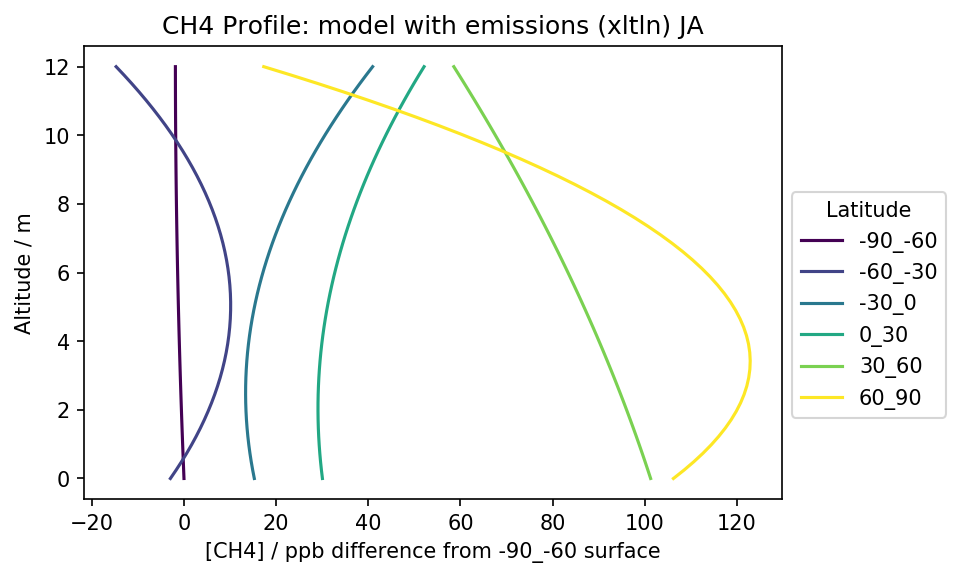

In [96]:
fig = plt.figure(dpi=150)
ax = plt.axes()
cmap = matplotlib.cm.get_cmap('viridis')

plt_labels=["-90_-60","-60_-30","-30_0","0_30","30_60","60_90"]

for i in range(6):
    #ax.plot(lat_mean - base[0], alt, label=f'{i} to {i+30}',c=cmap((i+90)/150))
    ax.plot(lat_bands_obs_jf[i,:] - base_obs_jf[0], yvals/1000, c=cmap(i/5) ,label=f'{plt_labels[i]}')
    
plt.legend(title='Latitude',bbox_to_anchor=(1.25,0.7))
#ax.set_ylim(0,12000)
#ax.set_xlim(-250,250)
plt.xlabel('[CH4] / ppb difference from -90_-60 surface')
plt.ylabel('Altitude / m')
plt.title(f'CH4 Profile: model with emissions (xltln) JA')

Text(0.5, 1.0, 'CH4')

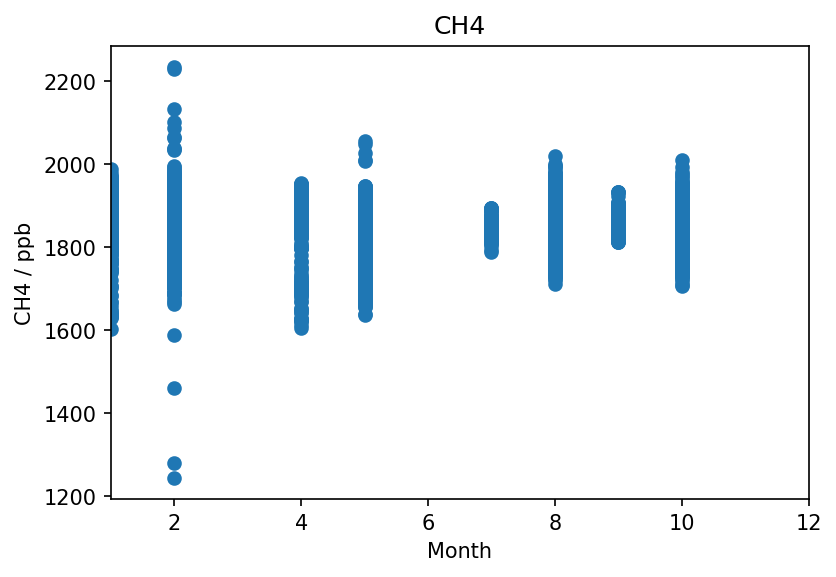

In [17]:
fig = plt.figure(dpi=150)
ax = plt.axes()
ax.scatter(ch4_data['month'],ch4_data.iloc[:,3])
ax.set_xlim(1,12)
plt.xlabel('Month')
plt.ylabel('CH4 / ppb')
plt.title(f'CH4')